# Training models to predict whether a team will run or pass, given their pre-snap alignment and shifts
This notebook:
1. Loads all available tracking data
2. Creates features for the play type prediction model, at two key frames: `line_set` and `ball_snap`
3. Trains LightGBM models, using the ball snap frames only
4. Predicts on the test set and saves predictions to a CSV

Relevant analysis is conducted in a different notebook. 

In [1]:
import sys
import os
import polars as pl
import pandas as pd
import itables

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, "../../", 'src'))

from config import Constants
from preprocessing.preprocessing import BigDataBowlData
from preprocessing.play_prediction import PlayPredictionModel
from plotting.plotting import PlotPlayVertical
import seaborn as sns

# init_notebook_mode(all_interactive=True)
pl.Config.set_tbl_cols(-1)
pl.Config.set_tbl_rows(100)


GAMES_FILE = "../../data/games.csv"
PLAYS_FILE = "../../data/plays.csv"
PLAYERS_FILE = "../../data/players.csv"
PLAYER_PLAYS_FILE = "../../data/player_play.csv"

TRACKING_FILES = ["../../data/tracking_week_1.csv",
                  "../../data/tracking_week_2.csv",
                    "../../data/tracking_week_3.csv",
                    "../../data/tracking_week_4.csv",
                    "../../data/tracking_week_5.csv",
                    "../../data/tracking_week_6.csv",
                    "../../data/tracking_week_7.csv",
                    "../../data/tracking_week_8.csv",
                    "../../data/tracking_week_9.csv",
                  ]

data = BigDataBowlData(GAMES_FILE, 
                       PLAYS_FILE, 
                       PLAYERS_FILE, 
                       PLAYER_PLAYS_FILE, 
                       TRACKING_FILES)

play_prediction = PlayPredictionModel(data)

In [2]:
model_features = []

play_dicts = data.plays_df.to_dicts()
for play_row in play_dicts:
    try:
        play_features = play_prediction.get_model_features(play_row["gameId"], play_row["playId"])
        model_features.append(play_features)
    except Exception as e:
        print(f"Error in play {play_row['gameId']} - {play_row['playId']}")
        print(f"Error: {e}")
        model_features.append(None)


Play 2022102302-1437 has no line set tracking data
Play 2022103005-121 has no ball snap tracking data
Play 2022092502-3024 has no line set tracking data
Play 2022110606-2006 has no ball snap tracking data
Play 2022091811-3377 has no line set tracking data
Play 2022100903-2016 has no line set tracking data
Play 2022100900-3273 has no ball snap tracking data
Play 2022103001-4479 has no line set tracking data
Play 2022103002-3333 has no line set tracking data
Play 2022100212-3804 has no line set tracking data
Play 2022102311-2901 has no line set tracking data
Play 2022100208-3365 has no ball snap tracking data
Play 2022091804-2685 has no ball snap tracking data
Play 2022102304-2362 has no ball snap tracking data
Play 2022100201-2252 has no line set tracking data
Play 2022101610-2955 has no ball snap tracking data
Play 2022103005-3379 has no line set tracking data
Play 2022091110-3449 has no line set tracking data
Play 2022102302-850 has no line set tracking data
Play 2022091811-2913 has n

In [3]:
parsed_model_features = [x for x in model_features if x is not None]

## Play prediction model

In [6]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [7]:
game_state_features = [x["game_state_features_with_target"] for x in parsed_model_features]
game_state_features_df = pd.DataFrame(game_state_features)

game_state_train_x = game_state_features_df[game_state_features_df["split"] == "train"].drop(columns=["gameId", "playId", "playType", "isPass", "split"])
game_state_train_y = game_state_features_df[game_state_features_df["split"] == "train"]["isPass"]

game_state_test_x = game_state_features_df[game_state_features_df["split"] == "test"].drop(columns=["gameId", "playId", "playType", "isPass", "split"])
game_state_test_y = game_state_features_df[game_state_features_df["split"] == "test"]["isPass"]

lgb_game_state_train = lgb.Dataset(data=game_state_train_x, label=game_state_train_y)
lgb_game_state_test = lgb.Dataset(data=game_state_test_x, label=game_state_test_y)

In [8]:

def run_hyperparameter_tuning(train_x, train_y, test_x, test_y):

    # Define the parameter grid
    param_grid = {
        'learning_rate': uniform(0.01, 0.3),  # Will sample between 0.01 and 0.31
        'n_estimators': randint(50, 300),     # Number of boosting rounds
        'max_depth': randint(3, 12),          # Maximum tree depth
        'num_leaves': randint(10, 100),       # Number of leaves in each tree
        'min_child_samples': randint(5, 50),  # Minimum number of data needed in a leaf
        'subsample': uniform(0.6, 0.4),       # Sampling ratio of training data
        'colsample_bytree': uniform(0.6, 0.4),# Sampling ratio of columns for each tree
        'reg_alpha': uniform(0, 2),           # L1 regularization
        'reg_lambda': uniform(0, 2),          # L2 regularization
    }

    # Create the LightGBM classifier
    base_model = lgb.LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        boosting_type='gbdt',
        random_state=4411
    )

    # Set up RandomizedSearchCV
    # n_iter controls how many parameter combinations to try
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=10,  # Number of parameter settings sampled
        cv=5,       # 5-fold cross-validation
        scoring='roc_auc',  # You can change this to other metrics like 'accuracy', 'f1', etc.
        n_jobs=-1,  # Use all available cores
        random_state=4411,
        verbose=2
    )

    # Fit the model
    # Note: Pass regular numpy arrays or pandas DataFrames, not LightGBM datasets
    search.fit(
        train_x,  # Your training features
        train_y,  # Your training labels
        eval_set=[(test_x, test_y)],
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )

    # Get the best parameters and score
    print("Best parameters found:", search.best_params_)
    print("Best cross-validation score:", search.best_score_)

    # Use the best model for predictions
    best_model = search.best_estimator_
    test_predictions = best_model.predict_proba(test_x)[:, 1]
    binary_predictions = [1 if p >= 0.5 else 0 for p in test_predictions]

    # Get accuracy and classification report
    print(f"Accuracy: {accuracy_score(test_y, binary_predictions)}")
    print("\nClassification Report:")

    best_classification_report = classification_report(test_y, binary_predictions)
    print(best_classification_report)

    return {"best_params": search.best_params_, 
            "best_score": search.best_score_, 
            "best_model": best_model, 
            "classification_report": best_classification_report}

In [10]:
# game_state_hyperparameters = run_hyperparameter_tuning(game_state_train_x, 
#                                                        game_state_train_y, 
#                                                        game_state_test_x, 
#                                                        game_state_test_y)

In [11]:
params = {
    'objective': 'binary',  # for binary classification
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'seed': 4411,
    'colsample_bytree': 0.8598722856399068, 
    'learning_rate': 0.2894774567880305, 
    'max_depth': 5, 
    'min_child_samples': 31, 
    'n_estimators': 211, 
    'num_leaves': 25, 
    'reg_alpha': 0.7829947387819356, 
    'reg_lambda': 1.1945847756567576, 
    'subsample': 0.9035520535570639
}


game_state_only_model = lgb.train(
    params,
    lgb_game_state_train,
    num_boost_round=100,
    valid_sets=[lgb_game_state_test],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Make predictions
game_state_test_predictions = game_state_only_model.predict(game_state_test_x)
game_state_binary_predictions = [1 if p >= 0.5 else 0 for p in game_state_test_predictions]  # Convert probabilities to binary predictions


[LightGBM] [Info] Number of positive: 6723, number of negative: 4300
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 11023, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.609907 -> initscore=0.446919
[LightGBM] [Info] Start training from score 0.446919
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

/workspaces/big_data_bowl_2025/.venv/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [12]:
# Make predictions
game_state_test_predictions = game_state_only_model.predict(game_state_test_x)
game_state_binary_predictions = [1 if p >= 0.5 else 0 for p in game_state_test_predictions]  # Convert probabilities to binary predictions

print(f"Accuracy: {accuracy_score(game_state_test_y, game_state_binary_predictions)}")
print("\nClassification Report:")
classification_report(game_state_test_y, game_state_binary_predictions, output_dict=True)

Accuracy: 0.697260834014718

Classification Report:


{'0': {'precision': 0.6292606187729418,
  'recall': 0.60790273556231,
  'f1-score': 0.6183973202782788,
  'support': 1974.0},
 '1': {'precision': 0.7407035175879397,
  'recall': 0.7577107607950652,
  'f1-score': 0.7491106217177707,
  'support': 2918.0},
 'accuracy': 0.697260834014718,
 'macro avg': {'precision': 0.6849820681804408,
  'recall': 0.6828067481786876,
  'f1-score': 0.6837539709980247,
  'support': 4892.0},
 'weighted avg': {'precision': 0.6957345310260415,
  'recall': 0.697260834014718,
  'f1-score': 0.6963657204419005,
  'support': 4892.0}}

In [13]:
roc_auc_score(game_state_test_y, game_state_test_predictions)

np.float64(0.7743194947615784)

In [14]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': game_state_only_model.feature_name(),
    'importance': game_state_only_model.feature_importance()
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                feature  importance
5  gameSecondsRemaining         150
4       scoreDifference         124
3     distanceToEndzone         120
2          logYardsToGo          69
1                  down          45
0               quarter          16


## Spatial features prediction model

In [15]:
ball_snap_spatial_features_with_target = [x["ball_snap_spatial_features_with_target"] for x in parsed_model_features]
line_set_spatial_features_with_target = [x["line_set_spatial_features_with_target"] for x in parsed_model_features]

ball_snap_spatial_features_df = pd.DataFrame(ball_snap_spatial_features_with_target)
line_set_spatial_features_df = pd.DataFrame(line_set_spatial_features_with_target)

spatial_ball_snap_train_x = ball_snap_spatial_features_df[ball_snap_spatial_features_df["split"] == "train"].drop(columns=["gameId", "playId", "playType", "isPass", "split"])
spatial_ball_snap_train_y = ball_snap_spatial_features_df[ball_snap_spatial_features_df["split"] == "train"]["isPass"]

spatial_ball_snap_test_x = ball_snap_spatial_features_df[ball_snap_spatial_features_df["split"] == "test"].drop(columns=["gameId", "playId", "playType", "isPass", "split"])
spatial_ball_snap_test_y = ball_snap_spatial_features_df[ball_snap_spatial_features_df["split"] == "test"]["isPass"]

spatial_line_set_test_x = line_set_spatial_features_df[line_set_spatial_features_df["split"] == "test"].drop(columns=["gameId", "playId", "playType", "isPass", "split"])
spatial_line_set_test_y = line_set_spatial_features_df[line_set_spatial_features_df["split"] == "test"]["isPass"]

lgb_spatial_ball_snap_train = lgb.Dataset(data=spatial_ball_snap_train_x, label=spatial_ball_snap_train_y)
lgb_spatial_ball_snap_test = lgb.Dataset(data=spatial_ball_snap_test_x, label=spatial_ball_snap_test_y)
lgb_spatial_line_set_test = lgb.Dataset(data=spatial_line_set_test_x, label=spatial_line_set_test_y)

In [16]:
# spatial_features_hyperparameters = run_hyperparameter_tuning(spatial_ball_snap_train_x,
#                                                              spatial_ball_snap_train_y,
#                                                              spatial_ball_snap_test_x,
#                                                              spatial_ball_snap_test_y)

In [17]:
params = {
    'objective': 'binary',  # for binary classification
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'seed': 4411,
    'colsample_bytree': 0.7159222217873522, 
    'learning_rate': 0.22232750493876458, 
    'max_depth': 5, 
    'min_child_samples': 43, 
    'n_estimators': 231, 
    'num_leaves': 10, 
    'reg_alpha': 1.5889162280086777, 
    'reg_lambda': 0.7731763927442281, 
    'subsample': 0.9317323990782951
    }

spatial_features_at_snap_model = lgb.train(
    params,
    lgb_spatial_ball_snap_train,
    num_boost_round=100,
    valid_sets=[lgb_spatial_ball_snap_test],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

[LightGBM] [Info] Number of positive: 6723, number of negative: 4300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7322
[LightGBM] [Info] Number of data points in the train set: 11023, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.609907 -> initscore=0.446919
[LightGBM] [Info] Start training from score 0.446919
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.476897


/workspaces/big_data_bowl_2025/.venv/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [18]:
# Make predictions
spatial_ball_snap_test_predictions = spatial_features_at_snap_model.predict(spatial_ball_snap_test_x)
spatial_ball_snap_binary_predictions = [1 if p >= 0.5 else 0 for p in spatial_ball_snap_test_predictions]  # Convert probabilities to binary predictions

spatial_line_set_test_predictions = spatial_features_at_snap_model.predict(spatial_line_set_test_x)

print(f"Accuracy: {accuracy_score(spatial_ball_snap_test_y, spatial_ball_snap_binary_predictions)}")
print("\nClassification Report:")
classification_report(spatial_ball_snap_test_y, spatial_ball_snap_binary_predictions, output_dict=True)

Accuracy: 0.7698282910874897

Classification Report:


{'0': {'precision': 0.7150101419878296,
  'recall': 0.7142857142857143,
  'f1-score': 0.7146477445514445,
  'support': 1974.0},
 '1': {'precision': 0.8068493150684931,
  'recall': 0.8074023303632625,
  'f1-score': 0.8071257279890374,
  'support': 2918.0},
 'accuracy': 0.7698282910874897,
 'macro avg': {'precision': 0.7609297285281613,
  'recall': 0.7608440223244883,
  'f1-score': 0.760886736270241,
  'support': 4892.0},
 'weighted avg': {'precision': 0.7697907444100243,
  'recall': 0.7698282910874897,
  'f1-score': 0.7698093871661003,
  'support': 4892.0}}

In [19]:
roc_auc_score(spatial_ball_snap_test_y, spatial_ball_snap_test_predictions)

np.float64(0.8450629256412874)

In [20]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': spatial_features_at_snap_model.feature_name(),
    'importance': spatial_features_at_snap_model.feature_importance()
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                                  feature  importance
3                           offense_depth          31
5                          offense_in_box          24
14   offense_depth_front_cluster_centroid          17
15    offense_width_left_cluster_centroid          16
4                           offense_width          13
19     offense_depth_middle_cluster_count          13
17   offense_width_right_cluster_centroid          12
1                  offense_x_rel_centroid          12
37  defense_depth_middle_cluster_centroid          12
12    offense_depth_back_cluster_centroid          11
9                   offense_average_speed          11
13  offense_depth_middle_cluster_centroid          10
27                          defense_depth           8
25                 defense_x_rel_centroid           8
20      offense_depth_front_cluster_count           7
33                  defense_average_speed           7
29                       defenders_in_box           7
35     

## Combined model, with game state and spatial features

In [21]:
ball_snap_game_state_and_spatial_features_with_target = [x["ball_snap_game_state_with_spatial_features_and_target"] for x in parsed_model_features]
line_set_game_state_and_spatial_features_with_target = [x["line_set_game_state_with_spatial_features_and_target"] for x in parsed_model_features]

ball_snap_game_state_and_spatial_features_df = pd.DataFrame(ball_snap_game_state_and_spatial_features_with_target)
line_set_game_state_and_spatial_features_df = pd.DataFrame(line_set_game_state_and_spatial_features_with_target)

game_state_and_spatial_ball_snap_train_x = ball_snap_game_state_and_spatial_features_df[ball_snap_game_state_and_spatial_features_df["split"] == "train"].drop(columns=["gameId", "playId", "playType", "isPass", "split"])
game_state_and_spatial_ball_snap_train_y = ball_snap_game_state_and_spatial_features_df[ball_snap_game_state_and_spatial_features_df["split"] == "train"]["isPass"]

game_state_and_spatial_ball_snap_test_x = ball_snap_game_state_and_spatial_features_df[ball_snap_game_state_and_spatial_features_df["split"] == "test"].drop(columns=["gameId", "playId", "playType", "isPass", "split"])
game_state_and_spatial_ball_snap_test_y = ball_snap_game_state_and_spatial_features_df[ball_snap_game_state_and_spatial_features_df["split"] == "test"]["isPass"]

game_state_and_spatial_line_set_test_x = line_set_game_state_and_spatial_features_df[line_set_game_state_and_spatial_features_df["split"] == "test"].drop(columns=["gameId", "playId", "playType", "isPass", "split"])
game_state_and_spatial_line_set_test_y = line_set_game_state_and_spatial_features_df[line_set_game_state_and_spatial_features_df["split"] == "test"]["isPass"]

lgb_game_state_and_spatial_ball_snap_train = lgb.Dataset(data=game_state_and_spatial_ball_snap_train_x, label=game_state_and_spatial_ball_snap_train_y)
lgb_game_state_and_spatial_ball_snap_test = lgb.Dataset(data=game_state_and_spatial_ball_snap_test_x, label=game_state_and_spatial_ball_snap_test_y)
lgb_game_state_and_spatial_line_set_test = lgb.Dataset(data=game_state_and_spatial_line_set_test_x, label=game_state_and_spatial_line_set_test_y)

In [22]:
# game_state_and_spatial_model_hyperparameters = run_hyperparameter_tuning(game_state_and_spatial_ball_snap_train_x,
#                                                                             game_state_and_spatial_ball_snap_train_y,
#                                                                             game_state_and_spatial_ball_snap_test_x,
#                                                                             game_state_and_spatial_ball_snap_test_y)

In [23]:
params = {
    'objective': 'binary',  # for binary classification
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'seed': 4411,
    }

game_state_and_spatial_features_at_snap_model = lgb.train(
    params,
    lgb_game_state_and_spatial_ball_snap_train,
    num_boost_round=100,
    valid_sets=[lgb_game_state_and_spatial_ball_snap_test],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Make predictions
game_state_and_spatial_ball_snap_test_predictions = game_state_and_spatial_features_at_snap_model.predict(game_state_and_spatial_ball_snap_test_x)
game_state_and_spatial_ball_snap_binary_predictions = [1 if p >= 0.5 else 0 for p in game_state_and_spatial_ball_snap_test_predictions]  # Convert probabilities to binary predictions

game_state_and_spatial_line_set_test_predicitons = game_state_and_spatial_features_at_snap_model.predict(game_state_and_spatial_line_set_test_x)

print(f"Accuracy: {accuracy_score(game_state_and_spatial_ball_snap_test_y, game_state_and_spatial_ball_snap_binary_predictions)}")
print("\nClassification Report:")
classification_report(game_state_and_spatial_ball_snap_test_y, game_state_and_spatial_ball_snap_binary_predictions, output_dict=True)

[LightGBM] [Info] Number of positive: 6723, number of negative: 4300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7778
[LightGBM] [Info] Number of data points in the train set: 11023, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.609907 -> initscore=0.446919
[LightGBM] [Info] Start training from score 0.446919
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.464206
Accuracy: 0.7735077677841373

Classification Report:


{'0': {'precision': 0.7191295546558705,
  'recall': 0.7198581560283688,
  'f1-score': 0.719493670886076,
  'support': 1974.0},
 '1': {'precision': 0.8103566529492455,
  'recall': 0.8098012337217272,
  'f1-score': 0.8100788481316421,
  'support': 2918.0},
 'accuracy': 0.7735077677841373,
 'macro avg': {'precision': 0.764743103802558,
  'recall': 0.7648296948750479,
  'f1-score': 0.764786259508859,
  'support': 4892.0},
 'weighted avg': {'precision': 0.7735450642266122,
  'recall': 0.7735077677841373,
  'f1-score': 0.7735262847868449,
  'support': 4892.0}}

In [24]:
roc_auc_score(game_state_and_spatial_ball_snap_test_y, game_state_and_spatial_ball_snap_test_predictions)

np.float64(0.8529714249604001)

In [26]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': game_state_and_spatial_features_at_snap_model.feature_name(),
    'importance': game_state_and_spatial_features_at_snap_model.feature_importance()
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                                  feature  importance
9                           offense_depth         107
2                            logYardsToGo          87
4                         scoreDifference          78
5                    gameSecondsRemaining          73
11                         offense_in_box          70
1                                    down          62
23   offense_width_right_cluster_centroid          59
15                  offense_average_speed          58
20   offense_depth_front_cluster_centroid          51
21    offense_width_left_cluster_centroid          50
18    offense_depth_back_cluster_centroid          50
7                  offense_x_rel_centroid          49
10                          offense_width          46
17                    offense_hull_volume          42
31                 defense_x_rel_centroid          42
43  defense_depth_middle_cluster_centroid          42
22  offense_width_middle_cluster_centroid          40
19  off

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

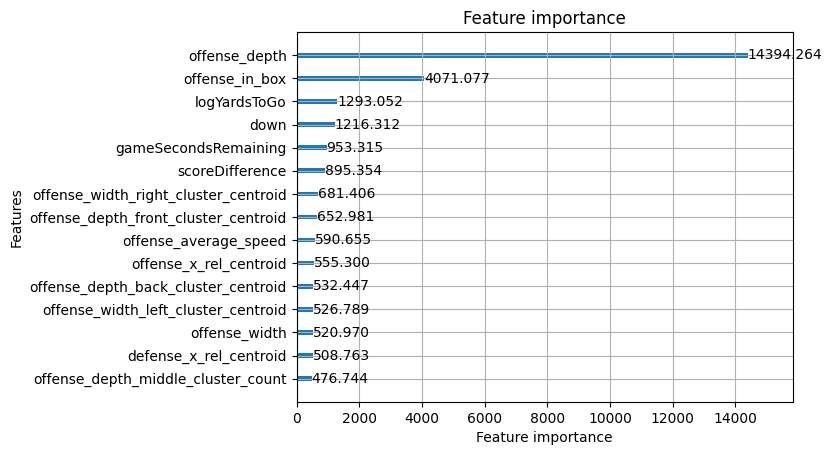

In [31]:
lgb.plot_importance(game_state_and_spatial_features_at_snap_model, importance_type='gain', max_num_features=15)

## Save results to CSV

In [27]:
list_of_plays = [x["ball_snap_game_state_with_spatial_features_and_target"] for x in parsed_model_features]
list_of_plays_df = pd.DataFrame(list_of_plays)
test_plays_df = list_of_plays_df[list_of_plays_df["split"] == "test"]

In [28]:
test_plays_df.head()

,gameId,playId,quarter,down,logYardsToGo,distanceToEndzone,scoreDifference,gameSecondsRemaining,offense_x_centroid,offense_x_rel_centroid,...,defense_width_right_cluster_centroid,defense_depth_back_cluster_count,defense_depth_middle_cluster_count,defense_depth_front_cluster_count,defense_width_left_cluster_count,defense_width_middle_cluster_count,defense_width_right_cluster_count,playType,isPass,split
0,2022102302,2655,3,1,2.302585,79,18,1014,29.221818,-1.358182,...,39.375000,7,3,1,4,5,2,pass,1,test
2,2022103004,3146,4,3,2.484907,80,-14,120,28.024545,-1.785454,...,43.010000,4,5,2,5,5,1,pass,1,test
3,2022110610,348,1,2,2.302585,23,0,3268,84.985455,-1.784546,...,34.806190,4,5,2,1,3,7,pass,1,test
4,2022102700,2799,3,2,2.079442,27,0,1036,80.576364,-2.243636,...,42.188333,6,4,1,3,6,2,run,0,test
6,2022110605,3861,4,1,2.302585,60,-23,29,47.868182,-1.611818,...,35.842000,8,1,2,2,4,5,run,0,test


In [29]:
play_info_list = [x["play_info"] for x in parsed_model_features]
play_info_df = pd.DataFrame(play_info_list)

test_plays_df_with_team = test_plays_df.merge(play_info_df[["gameId", "playId", "playDescription", "possessionTeam", "defensiveTeam", "expectedPointsAdded", "playHadMotionAndCameSet", "playHadPlayersInMotionAtSnap", "playHadPreSnapMotion"]], on=["gameId", "playId"])
test_plays_df_with_team["game_state_only_prob"] = game_state_test_predictions
test_plays_df_with_team["spatial_line_set_prob"] = spatial_line_set_test_predictions
test_plays_df_with_team["spatial_ball_snap_prob"] = spatial_ball_snap_test_predictions
test_plays_df_with_team["combined_line_set_prob"] = game_state_and_spatial_line_set_test_predicitons
test_plays_df_with_team["combined_ball_snap_prob"] = game_state_and_spatial_ball_snap_test_predictions

test_plays_df_with_team["change_in_spatial_prob"] = test_plays_df_with_team["spatial_ball_snap_prob"] - test_plays_df_with_team["spatial_line_set_prob"]
test_plays_df_with_team["change_in_combined_prob"] = test_plays_df_with_team["combined_ball_snap_prob"] - test_plays_df_with_team["combined_line_set_prob"]

test_plays_df_with_team.to_csv("test_set_play_type_predictions.csv", index=False)

test_plays_df_with_team["over_5_percent_change"] = np.where(abs(test_plays_df_with_team["change_in_combined_prob"]) > 0.05, 1, 0)
test_plays_df_with_team["over_10_percent_change"] = np.where(abs(test_plays_df_with_team["change_in_combined_prob"]) > 0.1, 1, 0)
test_plays_df_with_team["over_20_percent_change"] = np.where(abs(test_plays_df_with_team["change_in_combined_prob"]) > 0.2, 1, 0)

test_plays_df_with_team["pass_prob_increased_by_10_percent"] = np.where(test_plays_df_with_team["change_in_combined_prob"] > 0.1, 1, 0)
test_plays_df_with_team["run_prob_increased_by_10_percent"] = np.where(test_plays_df_with_team["change_in_combined_prob"] < -0.1, 1, 0)
test_plays_df_with_team["significant_prob_change"] = np.where(abs(test_plays_df_with_team["change_in_combined_prob"]) > 0.1, 1, 0)

test_plays_df_with_team["play_probability_change_category"] = np.where(test_plays_df_with_team["change_in_combined_prob"] > 0.1, "pass_prob_increased_by_10_percent", np.where(test_plays_df_with_team["change_in_combined_prob"] < -0.1, "run_prob_increased_by_10_percent", "no_significant_change"))

test_plays_df_with_team["is_bait_play"] = np.where((test_plays_df_with_team["play_probability_change_category"] == "pass_prob_increased_by_10_percent") & (test_plays_df_with_team["playType"] == "run"), 
                                                   1,
                                                   np.where((test_plays_df_with_team["play_probability_change_category"] == "run_prob_increased_by_10_percent") & (test_plays_df_with_team["playType"] == "pass"), 1, 0))

test_plays_df_with_team.to_csv("play_prediction_probabilities.csv", index=False)



In [2]:
import numpy as np
import matplotlib.pyplot as plt

test_plays_df_with_team = pd.read_csv("play_prediction_probabilities.csv")

test_plays_df_with_team["confusion_score"] = np.where(test_plays_df_with_team["isPass"] == 1, -np.log(test_plays_df_with_team["combined_ball_snap_prob"]), -np.log(1 - test_plays_df_with_team["combined_ball_snap_prob"]))
test_plays_df_with_team["confusion_score"] = np.where(test_plays_df_with_team["confusion_score"] <-1, -1, test_plays_df_with_team["confusion_score"])
test_plays_df_with_team["confusion_score"] = np.where(test_plays_df_with_team["confusion_score"] > 1, 1, test_plays_df_with_team["confusion_score"])

Text(0.5, 1.0, 'Confusion score vs EPA')

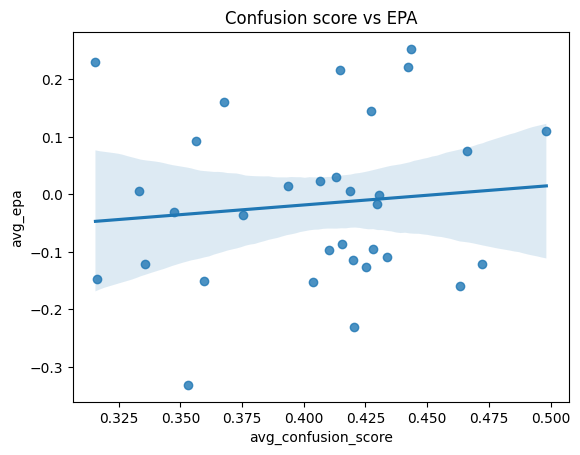

In [25]:
confusion_score_by_team = test_plays_df_with_team.groupby("possessionTeam").\
        agg(count=("play_probability_change_category", "count"),
        avg_confusion_score=("confusion_score", "mean"),
        avg_epa=("expectedPointsAdded", "mean"))

sns.regplot(data=confusion_score_by_team, x="avg_confusion_score", y="avg_epa")

plt.title("Confusion score vs EPA")

In [ ]:
test_plays_df_with_team.groupby(["play_probability_change_category"]).\
        agg(count=("play_probability_change_category", "count"),
        avg_epa=("expectedPointsAdded", "mean"),
        median_epa=("expectedPointsAdded", "median"))

,count,avg_epa,median_epa
play_probability_change_category,,,
no_significant_change,3472,-0.034558,-0.171993
pass_prob_increased_by_10_percent,732,0.046225,-0.162791
run_prob_increased_by_10_percent,688,-0.026302,-0.196587


In [133]:
test_plays_df_with_team.groupby(["play_probability_change_category", "is_bait_play"]).\
        agg(count=("play_probability_change_category", "count"),
        avg_epa=("expectedPointsAdded", "mean"),
        median_epa=("expectedPointsAdded", "median"))

count   avg_epa  median_epa
play_probability_change_category  is_bait_play                             
no_significant_change             0              3472 -0.034558   -0.171993
pass_prob_increased_by_10_percent 0               546  0.046072   -0.195891
                                  1               186  0.046676   -0.132508
run_prob_increased_by_10_percent  0               416 -0.068533   -0.209401
                                  1               272  0.038286   -0.172289

In [131]:
test_plays_df_with_team.groupby(["playType", "play_probability_change_category", "is_bait_play"]).\
        agg(count=("play_probability_change_category", "count"),
        avg_epa=("expectedPointsAdded", "mean"),
        median_epa=("expectedPointsAdded", "median"))

count   avg_epa  \
playType play_probability_change_category  is_bait_play                    
pass     no_significant_change             0              2100 -0.030654   
         pass_prob_increased_by_10_percent 0               546  0.046072   
         run_prob_increased_by_10_percent  1               272  0.038286   
run      no_significant_change             0              1372 -0.040533   
         pass_prob_increased_by_10_percent 1               186  0.046676   
         run_prob_increased_by_10_percent  0               416 -0.068533   

                                                         median_epa  
playType play_probability_change_category  is_bait_play              
pass     no_significant_change             0              -0.212910  
         pass_prob_increased_by_10_percent 0              -0.195891  
         run_prob_increased_by_10_percent  1              -0.172289  
run      no_significant_change             0              -0.133323  
         pass_prob_increased_by_10_percent 1              -0.132508  
         run_prob_increased_by_10_percent  0              -0.209401

In [4]:
test_plays_df_with_team.groupby(["is_bait_play"]).\
        agg(count=("is_bait_play", "count"),
        avg_epa=("expectedPointsAdded", "mean"),
        median_epa=("expectedPointsAdded", "median"))

,count,avg_epa,median_epa
is_bait_play,,,
0,4434,-0.027817,-0.181301
1,458,0.041693,-0.158375


In [6]:
test_plays_df_with_team.groupby(["playType", "is_bait_play"]).\
        agg(count=("is_bait_play", "count"),
        avg_epa=("expectedPointsAdded", "mean"),
        median_epa=("expectedPointsAdded", "median"))

count   avg_epa  median_epa
playType is_bait_play                             
pass     0              2646 -0.014822   -0.203053
         1               272  0.038286   -0.172289
run      0              1788 -0.047047   -0.155472
         1               186  0.046676   -0.132508

In [10]:
186/4892

0.03802125919869174

54.0%|-0.015|-0.203|
5.5%|0.038|-0.172|
36.5%|-0.047|-0.155|
3.8%|0.047|-0.132|


In [29]:
team_bait_rates = test_plays_df_with_team.\
    groupby(["possessionTeam"]).\
        agg(count=("play_probability_change_category", "count"),
        avg_epa=("expectedPointsAdded", "mean"),
        median_epa=("expectedPointsAdded", "median"),
        pre_snap_significant_change_rate=("significant_prob_change", "mean"),
        bait_rate=("is_bait_play", "mean")).reset_index(drop=False)

team_bait_rates

# team_bait_rate_efficiency =  test_plays_df_with_team.\
#          groupby(["possessionTeam", "is_bait_play"]).\
#         agg(count=("play_probability_change_category", "count"),
#         avg_epa=("expectedPointsAdded", "mean"),
#         median_epa=("expectedPointsAdded", "median")).reset_index(drop=False)


,possessionTeam,count,avg_epa,median_epa,pre_snap_significant_change_rate,bait_rate
0,ARI,175,-0.030256,-0.256960,0.274286,0.102857
1,ATL,161,-0.001870,-0.055352,0.403727,0.142857
2,BAL,193,0.022724,-0.013288,0.274611,0.098446
3,BUF,99,-0.121107,-0.182832,0.252525,0.060606
4,CAR,164,0.075012,-0.252618,0.365854,0.164634
5,CHI,194,0.109303,-0.058182,0.340206,0.087629
6,CIN,171,0.160010,0.046345,0.356725,0.093567
7,CLE,119,0.092642,-0.012419,0.168067,0.075630
8,DAL,110,0.220564,0.148174,0.181818,0.063636
9,DEN,131,-0.153172,-0.314852,0.221374,0.068702


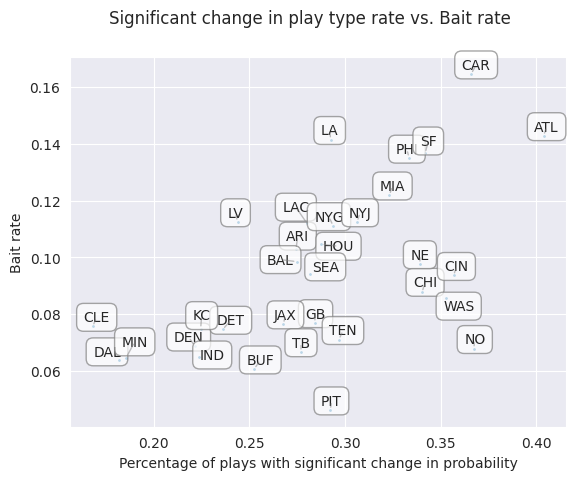

In [35]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
sns.set_style("darkgrid")
sns.scatterplot(data=team_bait_rates, x="pre_snap_significant_change_rate", y="bait_rate", s=5)
# Add text labels

texts = []

# Create annotations with boxes
for idx, row in team_bait_rates.iterrows():
    texts.append(
        plt.annotate(
            row['possessionTeam'],
            (row['pre_snap_significant_change_rate'], row['bait_rate']),
            bbox=dict(
                boxstyle='round,pad=0.5',
                fc='white',
                alpha=0.7,
                ec='gray'  # edge color for the box
            ),
            ha='center'
        )
    )

# Adjust the annotations to prevent overlap
adjust_text(
    texts,
    expand_points=(1.5, 1.5),
    arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5)  # optional connecting lines
)

plt.suptitle("Significant change in play type rate vs. Bait rate")
plt.xlabel("Percentage of plays with significant change in probability")
plt.ylabel("Bait rate")
plt.show()


In [36]:
team_bait_rate_efficiency =  test_plays_df_with_team.\
    groupby(["possessionTeam", "is_bait_play"]).\
    agg(count=("play_probability_change_category", "count"),
    avg_epa=("expectedPointsAdded", "mean"),
    median_epa=("expectedPointsAdded", "median")).reset_index(drop=False)

non_bait_efficiency = team_bait_rate_efficiency[team_bait_rate_efficiency["is_bait_play"] == 0]
bait_efficiency = team_bait_rate_efficiency[team_bait_rate_efficiency["is_bait_play"] == 1]

combined_bait_rate_efficiency = non_bait_efficiency.\
    merge(bait_efficiency, on="possessionTeam", suffixes=("_non_bait", "_bait")).\
    merge(team_bait_rates[["possessionTeam", "bait_rate"]], on="possessionTeam")

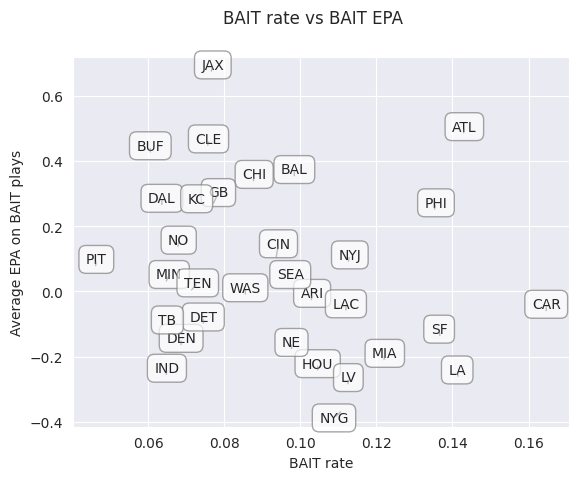

In [37]:
from adjustText import adjust_text

sns.scatterplot(data=combined_bait_rate_efficiency, x="bait_rate", y="avg_epa_bait", s=0)


texts = []

# Create annotations with boxes
for idx, row in combined_bait_rate_efficiency.iterrows():
    texts.append(
        plt.annotate(
            row['possessionTeam'],
            (row['bait_rate'], row['avg_epa_bait']),
            bbox=dict(
                boxstyle='round,pad=0.5',
                fc='white',
                alpha=0.7,
                ec='gray'  # edge color for the box
            ),
            ha='center'
        )
    )

# Adjust the annotations to prevent overlap
adjust_text(
    texts,
    expand_points=(1.5, 1.5),
    arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5)  # optional connecting lines
)

plt.suptitle("BAIT rate vs BAIT EPA")
plt.xlabel("BAIT rate")
plt.ylabel("Average EPA on BAIT plays")
plt.show()


In [ ]:
sns.kdeplot(data=test_plays_df_with_team, x="change_in_combined_prob", hue="possessionTeam", fill=True)

In [ ]:
com

In [168]:
team_bait_rate_efficiency

,possessionTeam,is_bait_play,count,avg_epa,median_epa
0,ARI,0,157,-0.029903,-0.253301
1,ARI,1,18,-0.033328,-0.268939
2,ATL,0,138,-0.081817,-0.130931
3,ATL,1,23,0.477811,0.103711
4,BAL,0,174,-0.012606,-0.047622
...,...,...,...,...,...
59,TB,1,13,-0.062747,-0.263659
60,TEN,0,144,-0.103557,-0.213307
61,TEN,1,11,-0.001193,-0.422171
62,WAS,0,171,-0.123038,-0.283778


In [123]:
688/4892

0.14063777596075225

In [118]:
test_plays_df_with_team.\
    groupby(["playType", "play_probability_change_category"]).\
        agg(count=("play_probability_change_category", "count"),
        avg_epa=("expectedPointsAdded", "mean"),
        median_epa=("expectedPointsAdded", "median"))

count   avg_epa  median_epa
playType play_probability_change_category                              
pass     no_significant_change               2100 -0.030654   -0.212910
         pass_prob_increased_by_10_percent    546  0.046072   -0.195891
         run_prob_increased_by_10_percent     272  0.038286   -0.172289
run      no_significant_change               1372 -0.040533   -0.133323
         pass_prob_increased_by_10_percent    186  0.046676   -0.132508
         run_prob_increased_by_10_percent     416 -0.068533   -0.209401

In [77]:
test_plays_df_with_team.\
    groupby(["playType", "play_probability_change_category"]).\
        agg(count=("play_probability_change_category", "count"),
        avg_epa=("expectedPointsAdded", "mean"),
        median_epa=("expectedPointsAdded", "median"))

count   avg_epa  median_epa
playType play_probability_change_category                              
pass     no_significant_change               2100 -0.030654   -0.212910
         pass_prob_increased_by_10_percent    546  0.046072   -0.195891
         run_prob_increased_by_10_percent     272  0.038286   -0.172289
run      no_significant_change               1372 -0.040533   -0.133323
         pass_prob_increased_by_10_percent    186  0.046676   -0.132508
         run_prob_increased_by_10_percent     416 -0.068533   -0.209401

In [65]:
np.mean(test_plays_df_with_team["over_20_percent_change"])

np.float64(0.09505314799672936)

In [69]:
test_plays_df_with_team.groupby(["playType", "over_5_percent_change"]).\
    agg(count=("over_5_percent_change", "count"),
        avg_epa=("expectedPointsAdded", "mean"),
        median_epa=("expectedPointsAdded", "median"))

count   avg_epa  median_epa
playType over_5_percent_change                             
pass     0                       1502 -0.047280   -0.240940
         1                       1416  0.029810   -0.159129
run      0                        869 -0.030236   -0.084487
         1                       1105 -0.044492   -0.206271

In [70]:
test_plays_df_with_team.groupby(["playType", "over_10_percent_change"]).\
    agg(count=("over_10_percent_change", "count"),
        avg_epa=("expectedPointsAdded", "mean"),
        median_epa=("expectedPointsAdded", "median"))

count   avg_epa  median_epa
playType over_10_percent_change                             
pass     0                        2100 -0.030654   -0.212910
         1                         818  0.043483   -0.186324
run      0                        1372 -0.040533   -0.133323
         1                         602 -0.032936   -0.185386

In [71]:
test_plays_df_with_team.groupby(["playType", "over_20_percent_change"]).\
    agg(count=("over_20_percent_change", "count"),
        avg_epa=("expectedPointsAdded", "mean"),
        median_epa=("expectedPointsAdded", "median"))

count   avg_epa  median_epa
playType over_20_percent_change                             
pass     0                        2626 -0.011335   -0.187690
         1                         292  0.003293   -0.339136
run      0                        1801 -0.040527   -0.147216
         1                         173 -0.014154   -0.219151

In [72]:
2+2

4

In [73]:
2+2

4

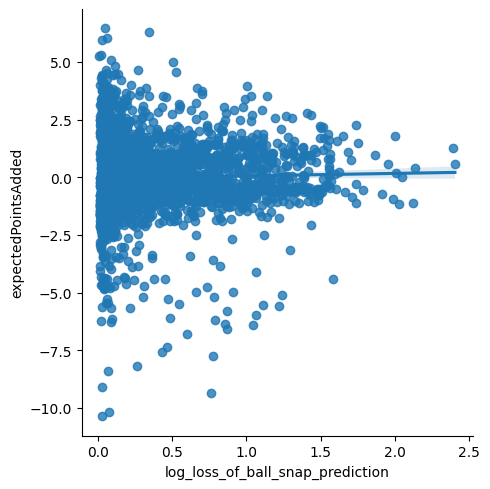

In [56]:
sns.lmplot(data=test_plays_df_with_team[test_plays_df_with_team["isPass"] == 1],
                x="log_loss_of_ball_snap_prediction",
                y="expectedPointsAdded")

In [ ]:
sns.kdeplot(data=test_plays_df_with_team[test_plays_df_with_team["isPass"] == 1],
                x="expectedPointsAdded",
                y="expectedPointsAdded")

In [49]:
test_plays_df_with_team["change_in_combined_prob"].describe()

count    4892.000000
mean        0.004452
std         0.123804
min        -0.792529
25%        -0.047289
50%         0.006007
75%         0.057106
max         0.722553
Name: change_in_combined_prob, dtype: float64

In [50]:
test_plays_df_with_team.sort_values("change_in_combined_prob", ascending=False).head()

,gameId,playId,quarter,down,logYardsToGo,distanceToEndzone,scoreDifference,gameSecondsRemaining,offense_x_centroid,offense_x_rel_centroid,...,game_state_only_prob,spatial_line_set_prob,spatial_ball_snap_prob,combined_line_set_prob,combined_ball_snap_prob,change_in_spatial_prob,change_in_combined_prob,combined_line_set_deception_score,combined_ball_snap_deception_score,log_loss_of_ball_snap_prediction
2185,2022110608,452,1,1,2.302585,30,-3,3149,77.676364,-1.633634,...,0.467438,0.353592,0.938356,0.216305,0.938858,0.584763,0.722553,0.783695,0.061142,0.063091
847,2022102310,767,1,3,1.386294,13,-10,2864,94.914545,-1.535451,...,0.883196,0.414571,0.917678,0.344436,0.957175,0.503107,0.612739,0.655564,0.042825,0.043769
2769,2022102303,2826,4,1,2.302585,79,-4,592,29.340909,-1.649089,...,0.592363,0.387101,0.980859,0.390992,0.968428,0.593758,0.577436,0.609008,0.031572,0.032081
3268,2022103006,3260,4,3,1.609438,51,24,356,57.190909,-1.529092,...,0.791674,0.435786,0.793304,0.280685,0.822232,0.357518,0.541548,0.719315,0.177768,0.195732
1974,2022103010,2636,4,2,1.609438,31,3,859,76.692727,-1.717276,...,0.431286,0.573609,0.917493,0.407548,0.902663,0.343883,0.495115,0.592452,0.097337,0.102406


In [51]:
test_plays_df_with_team.head()

,gameId,playId,quarter,down,logYardsToGo,distanceToEndzone,scoreDifference,gameSecondsRemaining,offense_x_centroid,offense_x_rel_centroid,...,game_state_only_prob,spatial_line_set_prob,spatial_ball_snap_prob,combined_line_set_prob,combined_ball_snap_prob,change_in_spatial_prob,change_in_combined_prob,combined_line_set_deception_score,combined_ball_snap_deception_score,log_loss_of_ball_snap_prediction
0,2022102302,2655,3,1,2.302585,79,18,1014,29.221818,-1.358182,...,0.421760,0.875775,0.966138,0.868489,0.954371,0.090363,0.085882,0.131511,0.045629,0.046703
1,2022103004,3146,4,3,2.484907,80,-14,120,28.024545,-1.785454,...,0.972673,0.727244,0.941106,0.662838,0.982003,0.213862,0.319165,0.337162,0.017997,0.018161
2,2022110610,348,1,2,2.302585,23,0,3268,84.985455,-1.784546,...,0.617190,0.941180,0.898290,0.935905,0.907400,-0.042889,-0.028505,0.064095,0.092600,0.097172
3,2022102700,2799,3,2,2.079442,27,0,1036,80.576364,-2.243636,...,0.700879,0.250731,0.231155,0.373693,0.310816,-0.019575,-0.062877,-0.373693,-0.310816,0.372247
4,2022110605,3861,4,1,2.302585,60,-23,29,47.868182,-1.611818,...,0.934691,0.860648,0.742743,0.939516,0.838128,-0.117905,-0.101389,-0.939516,-0.838128,1.820946


In [47]:
test_plays_df_with_team.\
    groupby("possessionTeam").\
        agg(count=("gameId", "count"), 
            avg_change=("change_in_combined_prob", "mean"), 
            avg_deception_score=("log_loss_of_ball_snap_prediction", "mean"), 
            avg_epa=("expectedPointsAdded", "mean")).sort_values("avg_epa", ascending=False)

KeyError: "Column(s) ['log_loss_of_ball_snap_prediction'] do not exist"

In [42]:
2+2

4

In [80]:
play_to_plot = data.tracking_data.filter((pl.col("gameId") == 2022110608) & (pl.col("playId") == 452)).collect()

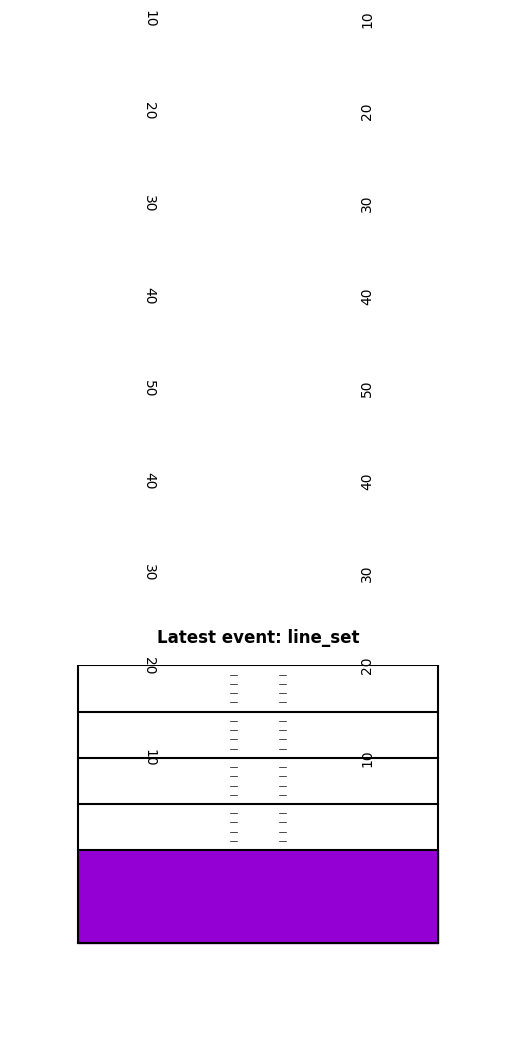

In [85]:
from plotting.plotting import PlotPlayVertical

play = PlotPlayVertical(play_to_plot)
# play.animate_play()

play.max_x = 20
play.plot_frame(30)

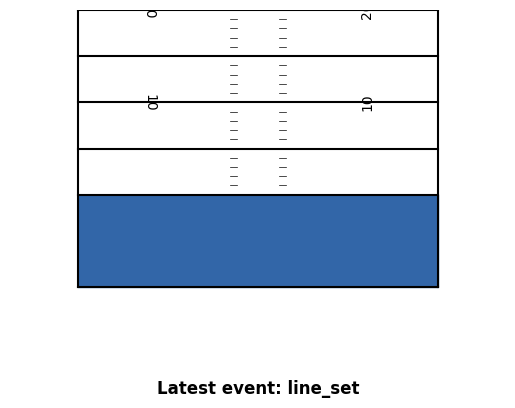

In [87]:
play = PlotPlayVertical(play_to_plot)
# play.animate_play()

play.max_x = 20
play.plot_frame(30)

## Model
54 features used to train the model:
- 6 game state features (derived from play information)
- 24 offensive team features (derived from tracking data)
- 24 defensive team features (derived from tracking data)

Game state features were inspired by [Ron Yurko's nflWAR](https://arxiv.org/abs/1802.00998) paper.
- `quarter`: The play quarter
- `down`: The play down
- `logYardsToGo`: The natural log of the yards required for a first down
- `distanceToEndzone`: The number of yards to the defending team's endzone
- `scoreDifference`: The score difference of the possession team before the play(ie. team score - defense score)
- `gameSecondsRemaining`: The seconds remaining in the game

Spatial features were inspired by the football paper [Is it worth the effort? Understanding and
contextualizing physical metrics in soccer](https://arxiv.org/pdf/2204.02313) by Llana et. al. (2022). This introduced ways of using tracking data to quantify the shape and spacing features of in and out of possession formation structures, and the same concept can be applied to American football. 

The following features were calculated for both the offense and defense:
- `team_x_centroid`: The x-centroid of the team,
- `team_x_rel_centroid`: The x-centroid of the team, relative to the line of scrimmage (ie. the average of x - x_line_of_scrimmage),
- `team_y_centroid`: The y-centroid of the team,
- `team_depth`: The x distance between the player closest to the line of scrimmage and the player furthest from the line of scrimmage
- `team_width`: The y distance between the left most player and the right most player
- `team_in_box`: On offense, this was defined as the number of players within the box created by spanning 6 yards either side of the ball spot, and 8 yards away from the line of scrimmage. On defense, this was the number of players who were within 4 yards either side of the ball spot, and 5 yards away from the line of scrimmage
- `team_left_side`: The number of players to the left of the ball spot
- `team_right_side`: The number of players to the right of the ball spot
- `team_in_motion`: The number of players with speed > 0.6 in the frame
- `team_average_speed`: The average speed of players
- `team_hull_perimeter`: Calculated using `ConvexHull`, the perimeter of the convex hull that describes the team
- `team_hull_volume`: Calculated using `ConvexHull`, the area of the convex hull that describes the team

The final features were created by using K-means clustering to cluster the x-coordinates and y-coordinates (separately) into 3 clusters. Horizontally, this created "left", "middle" and "right" clusters. Vertically, this created "front", "middle" and "back" clusters. The idea is to quantify the space between different levels of defense, to understand the relative positioning and shape of the team.
- `team_depth_back_cluster_centroid`: The x centroid of the back depth cluster
- `team_depth_middle_cluster_centroid`: The x centroid of middle depth cluster
- `team_depth_front_cluster_centroid`: The x centroid of the front depth cluster
- `team_width_left_cluster_centroid`: The y centroid of the left width cluster
- `team_width_middle_cluster_centroid`: The y centroid of the middle width cluster
- `team_width_right_cluster_centroid`: The y centroid of the right width cluster
- `team_depth_back_cluster_count`: The number of players in the back depth cluster
- `team_depth_middle_cluster_count`: The number of players in the middle depth cluster
- `team_depth_front_cluster_count`: The number of players in the front depth cluster
- `team_width_left_cluster_count`: The number of players in the left width cluster
- `team_width_middle_cluster_count`: The number of players in the middle width cluster
- `team_width_right_cluster_count`: The number of players in the right width cluster